# [Attention Monitoring](https://nycdatascience.com/blog/student-works/attention-monitoring/) with Apache MXNet on AWS

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
3. [Fine-tuning the Image classification model](#Fine-tuning-the-Image-classification-model)
4. [Training parameters](#Training-parameters)
5. [Start the training](#Start-the-training)
6. [Inference](#Inference)


## Introduction

This is an end-to-end example of an distributed image classification algorithm in transfer learning mode. I used the *SageMaker Image Classification Transfer Learning Highlevel* demo [notebook](https://github.com/aws/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/imageclassification_caltech/Image-classification-transfer-learning-highlevel.ipynb) as a template.

Here, the Amazon sagemaker image classification algorithm is used in transfer learning mode to fine-tune a pre-trained model (trained on imagenet data) to learn to classify a new dataset. In particular, the pre-trained model will be fine-tuned using my Attention Monitoring dataset. 

This notebook was tested in Amazon SageMaker Studio on ml.t3.medium instance with Python 3 (Data Science) kernel. *You should request a limit instance before running this notebook to avoid further delays. [Scroll down](#Start-the-training) for more information.*

To get started, you need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

Here I set up the linkage and authentication to AWS services. There are three parts to this:

* The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
* The S3 bucket that you want to use for training and model data
* The Amazon sagemaker image classification docker image which need not be changed

**Note:** I followed the instructions listed [here](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/imageclassification_caltech/Image-classification-lst-format.html#Prepare-the-data) to prepare the data for the image classification algorithm. I prepared the data locally then uploaded all of it, included the original images, to an S3 bucket, but it could be done in SageMaker.

Using the [im2rec script](https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py) from MXNet:
- Commands to create the .lst files: 
    - python im2rec.py --list --recursive train ../data/train/
    - python im2rec.py --list --recursive validation ../data/valid/
    - python im2rec.py --list --recursive test ../data/test/
- Commands to create the RecordIO files:
    - python im2rec.py --resize 224 --quality 90 train ../data/train/
    - python im2rec.py --resize 224 --quality 90 validation ../data/valid/
    - python im2rec.py --resize 224 --quality 90 test ../data/test/

**Note:** Both input and output buckets are now public:
- Input: s3://attention-monitoring
- Ouput: s3://sagemaker-us-east-2-090819523734/ic-transfer-learning/

In [1]:
%%time
import boto3
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)

region = boto3.Session().region_name

s3_client = boto3.client("s3")

sess = sagemaker.Session()
data_bucket = f"attention-monitoring"
data_prefix = "data/"

output_bucket = sess.default_bucket()
output_prefix = "ic-transfer-learning"

s3_client.download_file(
    data_bucket, data_prefix + "train.rec", "train.rec"
)
s3_client.download_file(
    data_bucket, data_prefix + "validation.rec", "val.rec"
)

s3_client.upload_file(
    "train.rec", output_bucket, output_prefix + "/train_rec/train.rec"
)
s3_client.upload_file(
    "val.rec",
    output_bucket,
    output_prefix + "/validation_rec/val.rec",
)

arn:aws:iam::090819523734:role/service-role/AmazonSageMaker-ExecutionRole-20210810T160366
CPU times: user 1.93 s, sys: 1.14 s, total: 3.08 s
Wall time: 3.83 s


In [2]:
from sagemaker import image_uris

training_image = image_uris.retrieve("image-classification", sess.boto_region_name)
print(training_image)

825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:1


## Fine-tuning the Image classification model

The Attention Monitoring data (s3://attention-monitoring/data/) consist of 10427 images from 2 classes.

Here is how I partitioned the data:
- Train: 7302 images belonging to 2 classes
- Validate: 1561 images belonging to 2 classes.
- Test: 1564 images belonging to 2 classes.

The image classification algorithm can take two types of input formats. The first is a recordio format and the other is a lst format. Files for both formats are available at the s3 bucket I linked above. I used the recordio format for training in this notebook. 

In [3]:
import boto3

s3train = f"s3://{output_bucket}/{output_prefix}/train_rec/"
s3validation = f"s3://{output_bucket}/{output_prefix}/validation_rec/"

Once the data is available in the correct format for training, the next step is to actually train the model using the data. Before training the model, you need to setup the training parameters. The next section will explain the parameters in detail.

## Training
Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let I create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.
### Training parameters
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

* **Training instance count**: This is the number of instances on which to run the training. When the number of instances is greater than one, then the image classification algorithm will run in distributed settings. 
* **Training instance type**: This indicates the type of machine on which to run the training. Typically, GPU instances are used for these trainings. 
* **Output path**: This the s3 folder in which the training output is stored

In [4]:
s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"
ic = sagemaker.estimator.Estimator(
    training_image,
    role,
    instance_count=1,
    instance_type="ml.p2.xlarge",
    volume_size=50,
    max_run=360000,
    input_mode="File",
    output_path=s3_output_location,
    sagemaker_session=sess,
)

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. These are:

* **num_layers**: The number of layers (depth) for the network. I use 152 in this notebook but other values such as 18 and 50 can be used.
* **use_pretrained_model**: Set to 1 to use pretrained model for transfer learning.
* **image_shape**: The input image dimensions,'num_channels, height, width', for the network. It should be no larger than the actual image size. The number of channels should be same as the actual image.
* **num_classes**: This is the number of output classes for the new dataset. Imagenet was trained with 1000 output classes but the number of output classes can be changed for fine-tuning. For attention-monitoring, I use 2 for the 2 categories: *attentive* and *notattentive*.
* **num_training_samples**: This is the total number of training samples. It is set to 7302 for attention-monitoring dataset with the current split.
* **mini_batch_size**: The number of training samples used for each mini batch. In distributed training, the number of training samples used per batch will be N * mini_batch_size where N is the number of hosts on which training is run.
* **epochs**: Number of training epochs.
* **learning_rate**: Learning rate for training.
* **precision_dtype**: Training datatype precision (default: float32). If set to 'float16', the training will be done in mixed_precision mode and will be faster than float32 mode


In [5]:
ic.set_hyperparameters(
    num_layers=152,
    use_pretrained_model=1,
    image_shape="3,224,224",
    num_classes=2,
    num_training_samples=7302,
    mini_batch_size=32,
    epochs=2,
    learning_rate=0.01,
    precision_dtype="float32",
)

## Input data specification
Set the data type and channels used for training

In [6]:
train_data = sagemaker.inputs.TrainingInput(
    s3_data=s3train,
    distribution="FullyReplicated",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    s3_data=s3validation,
    distribution="FullyReplicated",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
)

data_channels = {"train": train_data, "validation": validation_data}

## Start the training
Start training by calling the fit method in the estimator.

**NOTE**: You will likely receive the following error if you run the next cell: 
*ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateTrainingJob operation: The account-level service limit 'ml.p2.xlarge for training job usage' is 0 Instances, with current utilization of 0 Instances and a request delta of 1 Instances. Please contact AWS support to request an increase for this limit.*


This is how to request a limit increase: 
1. Visit aws console https://console.aws.amazon.com/
2. Vlick on Support on the top right corner
3. Select Support Center
4. Click create a case (orange button)
5. Select Service Limit radio button
6. Under **Case details**, for Limit type search and select SageMaker Training Jobs
7. Under **Requests**, select the same region as the region that is displayed on the top right corner of your AWS Management Console.
8. Select SageMaker Training as Resource Type
9. Select ml.p2.xlarge in Limit
10. Set New Limit Value to 1

*I tweaked these instructions: https://medium.com/data-science-bootcamp/amazon-sagemaker-ml-p2-xlarge-8b9cbc0dd7d*

It usually takes 24-48 hours to get the limit increase. Afterwards, run the next cell.

In [7]:
ic.fit(inputs=data_channels, logs=True)

2021-08-23 12:15:39 Starting - Starting the training job...
2021-08-23 12:16:02 Starting - Launching requested ML instancesProfilerReport-1629720939: InProgress
......
2021-08-23 12:17:02 Starting - Preparing the instances for training.........
2021-08-23 12:18:29 Downloading - Downloading input data...
2021-08-23 12:19:02 Training - Downloading the training image.....Docker entrypoint called with argument(s): train
[08/23/2021 12:19:49 INFO 139918038857536] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/image_classification/default-input.json: {'use_pretrained_model': 0, 'num_layers': 152, 'epochs': 30, 'learning_rate': 0.1, 'lr_scheduler_factor': 0.1, 'optimizer': 'sgd', 'momentum': 0, 'weight_decay': 0.0001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps': 1e-08, 'gamma': 0.9, 'mini_batch_size': 32, 'image_shape': '3,224,224', 'precision_dtype': 'float32'}
[08/23/2021 12:19:49 INFO 139918038857536] Merging with provided configuration from /opt/ml/input/config/hyper

# Inference

***

A trained model does nothing on its own. I now want to use the model to perform inference, that means predicting the class of the image. You can deploy the created model by using the deploy method in the estimator

In [8]:
ic_classifier = ic.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

---------------!

### List of object categories

In [9]:
object_categories = [ "attentive", "notattentive" ]

### Download test image

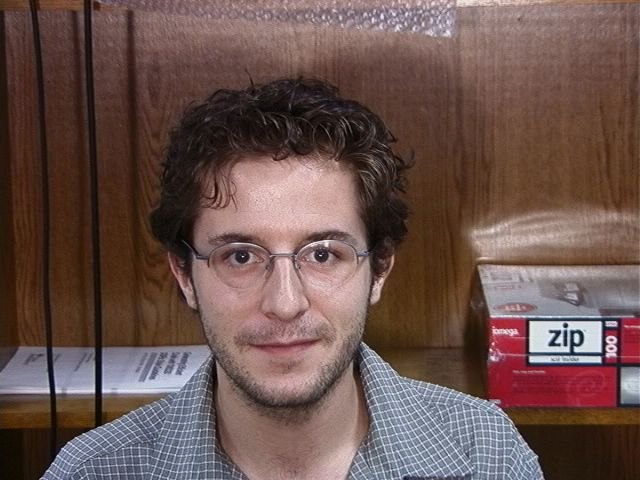

In [10]:
# test image
file_name = "/tmp/test.jpg"
s3_client.download_file(
    "attention-monitoring",
    "data/test_combined/0_000.jpg",
    file_name,
)

from IPython.display import Image

Image(file_name)

### Evaluation

Evaluate the image through the network for inteference. The network outputs class probabilities and typically, one selects the class with the maximum probability as the final class output.

**Note:** The output class detected by the network may not be accurate in this example. To limit the time taken and cost of training, I only trained the model only for a couple of epochs. If the network is trained for more epochs (say 20), then the output class will be more accurate.

In [11]:
import json
import numpy as np

with open(file_name, "rb") as f:
    payload = f.read()
    payload = bytearray(payload)

# Invoke the deployed model to compute prediction
prediction = ic_classifier.predict(payload, initial_args={"ContentType": "application/x-image"})

# prediction is a JSON string. Load it into a Python object.
probabilities = json.loads(prediction)

# find the class with maximum probability and print the class index
predicted_category_index = np.argmax(probabilities)
predicted_category_name = object_categories[predicted_category_index]
confidence = probabilities[predicted_category_index]

print(f"Result: label -  {predicted_category_name}, probability - {confidence}")

Result: label -  notattentive, probability - 0.5399425625801086


### Clean up

When you're done with the endpoint, you can just delete it and the backing instances will be released.  Run the following cell to delete the endpoint.

In [ ]:
ic_classifier.delete_endpoint()